In [1]:
import gensim
import pandas as pd
import numpy as np
import seaborn as sns
import mpu.ml

from nltk.tokenize import TweetTokenizer
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [20]:
# Ensures that tweet and user ids do not appear in scientific notation
pd.options.display.float_format = '{:.0f}'.format

# CNN Baseline Model

In [96]:
# Language: 'German', 'Italian', etc.
language = 'Spanish'

# Associated aligned word vector file
aligned_word_vec_file = {'Dutch':'wiki.nl.align.vec', 
                         'German': 'wiki.de.align.vec', 
                         'Italian':'wiki.it.align.vec', 
                         'Spanish':'wiki.es.align.vec'}

In [97]:
train = pd.read_csv('../NLP_MBTI_Classification/twisty_train.csv', index_col=0)
train = train[train['language'] == language]
train

,confirmed_tweet_ids,user_id,mbti,twitter_text,language
9708,687798790003240960,345623496,INFP,Mi hermano me vino a preguntar por qué nadie c...,Spanish
10112,392331160790917120,23844544,INTP,"@La_Kalaka @rethis no, sigue funcionando, pero...",Spanish
1289,205074560171769856,67075357,INFP,@yelvarez @UdeA Pero son los resultados de rei...,Spanish
16129,642850737546858496,87853831,ESTJ,"La #Justicia es #ética #equidad y #honradez, e...",Spanish
1939,600149807034957824,1535630690,INTJ,"@FlorenciaMayere como se nos pego el ""aguantaa...",Spanish
...,...,...,...,...,...
7515,390834862120128512,48157317,ENFP,Tranquilidad por fin,Spanish
6896,92757147439464448,127456021,ENFP,bernardo en #40&20 sube el ánimo girls... ja.,Spanish
1090,684039232365662208,757039206,INFP,"Lo triste de este anime, que los episodios no ...",Spanish
131,35074316831952896,72780318,ENFP,#creoquedeberias tener mas sexo y menos tweets :p,Spanish


In [98]:
test = pd.read_csv('../NLP_MBTI_Classification/twisty_test.csv', index_col=0)
test = test[test['language'] == language]
test

,confirmed_tweet_ids,user_id,mbti,twitter_text,language
8758,526609597063528448,57098445,ENTP,🎵 Tengo este amor de una noche que se olvida c...,Spanish
10626,22892461271,103127704,ENFP,Quiero llorar tanto hasta no sentir nada! Y da...,Spanish
12382,684765538095075328,479330668,ISTP,Solo hoy pido que se mantenga sin llover solo ...,Spanish
17392,295830904587304960,93913645,INFP,@Golimadefresa @Marialjim @Marsealonso @Aitana...,Spanish
17869,356094032667082752,125142570,ESFJ,Como me rei cuando me contaron como te caiste ...,Spanish
...,...,...,...,...,...
11091,529063504188542976,366159371,ESFP,Dice la tradición que porque no te pongo Flore...,Spanish
15111,672112676089307136,188691082,INFJ,"@AliciaJjm6 Acerquese señorita&lt;3, ""Todo emp...",Spanish
5135,618787264475308032,74829140,ISFP,"A todo esto, yo aún no he comido xd",Spanish
6993,40581986842050560,147647853,ESFP,"@JennHernandz ya lo sigo, pero hago RT!!! =)",Spanish


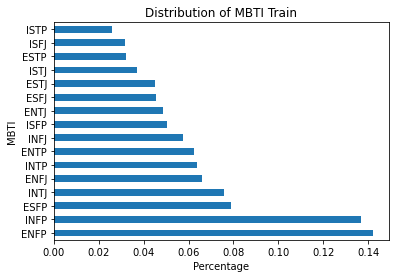

In [99]:
train['mbti'].value_counts(normalize=True).plot.barh()

plt.title('Distribution of MBTI Train')
plt.xlabel('Percentage')
plt.ylabel('MBTI');

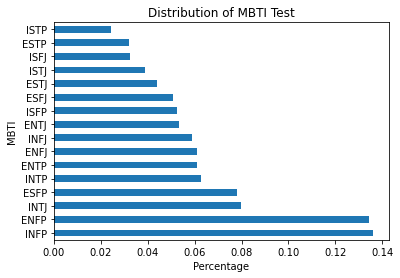

In [100]:
test['mbti'].value_counts(normalize=True).plot.barh()

plt.title('Distribution of MBTI Test')
plt.xlabel('Percentage')
plt.ylabel('MBTI');

In [101]:
mbti_num_encoding = {
    'ISTJ':0, 'ISFJ':1, 'INFJ':2, 'INTJ':3,
    'ISTP':4, 'ISFP':5, 'INFP':6, 'INTP':7,
    'ESTP':8, 'ESFP':9, 'ENFP':10, 'ENTP':11,
    'ESTJ':12, 'ESFJ':13, 'ENFJ':14, 'ENTJ':15}

In [102]:
train['mbti_encoding'] = train['mbti'].apply(lambda x: mbti_num_encoding[x])
test['mbti_encoding'] = test['mbti'].apply(lambda x: mbti_num_encoding[x])

In [103]:
train = train[['twitter_text', 'mbti_encoding']]
train

,twitter_text,mbti_encoding
9708,Mi hermano me vino a preguntar por qué nadie c...,6
10112,"@La_Kalaka @rethis no, sigue funcionando, pero...",7
1289,@yelvarez @UdeA Pero son los resultados de rei...,6
16129,"La #Justicia es #ética #equidad y #honradez, e...",12
1939,"@FlorenciaMayere como se nos pego el ""aguantaa...",3
...,...,...
7515,Tranquilidad por fin,10
6896,bernardo en #40&20 sube el ánimo girls... ja.,10
1090,"Lo triste de este anime, que los episodios no ...",6
131,#creoquedeberias tener mas sexo y menos tweets :p,10


In [104]:
test = test[['twitter_text', 'mbti_encoding']]
test

,twitter_text,mbti_encoding
8758,🎵 Tengo este amor de una noche que se olvida c...,11
10626,Quiero llorar tanto hasta no sentir nada! Y da...,10
12382,Solo hoy pido que se mantenga sin llover solo ...,4
17392,@Golimadefresa @Marialjim @Marsealonso @Aitana...,6
17869,Como me rei cuando me contaron como te caiste ...,13
...,...,...
11091,Dice la tradición que porque no te pongo Flore...,9
15111,"@AliciaJjm6 Acerquese señorita&lt;3, ""Todo emp...",2
5135,"A todo esto, yo aún no he comido xd",5
6993,"@JennHernandz ya lo sigo, pero hago RT!!! =)",9


# Creating Word Embedding Matrix

Aligned Word Vector (fastText): https://fasttext.cc/docs/en/aligned-vectors.html

Gensim API: https://radimrehurek.com/gensim/apiref.html

In [105]:
with open(aligned_word_vec_file[language], 'r') as f:
    first_line = f.readline().split()
    print('Number of words:', first_line[0])
    print('Vector Length:', first_line[1])

Number of words: 985667
Vector Length: 300


In [106]:
max_word_limit = 50000 # Limit due to kernal memory constraint
model = gensim.models.KeyedVectors.load_word2vec_format(aligned_word_vec_file[language], limit=max_word_limit)

In [107]:
# initialize embedding matrix and word-to-id map:
embedding_matrix = np.zeros((max_word_limit + 1, int(first_line[1])))       
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(model.vocab.keys()):
    embedding_vector = model[word]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

# Tokenize Text

In [108]:
# Split data into twitter text and mbti number encoding
X_train = train['twitter_text']
y_train = train['mbti_encoding']

X_test = test['twitter_text']
y_test = test['mbti_encoding']

# Convert number encoding to one hot vector
#import mpu.ml
y_train = np.array(mpu.ml.indices2one_hot(y_train, nb_classes=16))
y_test = np.array(mpu.ml.indices2one_hot(y_test, nb_classes=16))

In [109]:
# Twitter tokenizer specific for tweets
# preserve_case=False converts everything to lowercase
# strip_handles remove Twitter username handles from text
# reduce_len=True replace repeated character sequences of length 3 or greater with sequences of length 3
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

# This is to identify the longest token sequence after the tokenizer has been applied to it
# This number will be used for padding and initial configuration of CNN model below
MAX_SEQUENCE_LENGTH = 0
for sentence in train['twitter_text']:
    token_length = len(tokenizer.tokenize(sentence))
    MAX_SEQUENCE_LENGTH = max(MAX_SEQUENCE_LENGTH, token_length)
    
for sentence in test['twitter_text']:
    token_length = len(tokenizer.tokenize(sentence))
    MAX_SEQUENCE_LENGTH = max(MAX_SEQUENCE_LENGTH, token_length)

print("Max token length:", MAX_SEQUENCE_LENGTH)

Max token length: 42


In [110]:
#tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

def sents_to_ids(sentences):
    """
    converting a list of strings to a list of lists of word ids
    """
    max_length = MAX_SEQUENCE_LENGTH
    text_ids = np.zeros((1, max_length), dtype=int)
    for sentence in sentences:
        example = []
        for word in tokenizer.tokenize(sentence):
            if word in vocab_dict.keys():
                example.append(vocab_dict[word])
            #else:
            #    example.append(0)

        example = np.pad(example, (0, max_length-len(example)))
        text_ids = np.vstack((text_ids, example))
    
    text_ids = np.delete(text_ids, 0, axis=0)

    return text_ids

X_train = sents_to_ids(X_train)
X_test = sents_to_ids(X_test)

# Train CNN NLP Model

Example of CNN: https://github.com/datasci-w266/2021-spring-main/blob/master/materials/lesson_notebooks/lesson_5_cnn.ipynb

https://medium.com/saarthi-ai/sentence-classification-using-convolutional-neural-networks-ddad72c7048c

In [111]:
embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

def cnn_model(optimizer='adam', epochs_input=30, batch_size_input=32, under_represented_weighting=False):
    
    # CNN Model Architecture
    tf_model = tf.keras.Sequential()
    tf_model.add(embedding_layer)
    tf_model.add(tf.keras.layers.Conv1D(
                filters=10, 
                kernel_size=3, 
                strides=1, 
                padding='same', 
                activation='relu', 
                use_bias=True,
                kernel_initializer='glorot_uniform', 
                bias_initializer='zeros')) 
    tf_model.add(tf.keras.layers.GlobalMaxPooling1D())
    tf_model.add(Dense(100, activation='relu'))
    tf_model.add(Dense(16, activation='sigmoid'))
    
    tf_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])
    
    if under_represented_weighting != False:
        # Class weight helps to tell the model to "pay more attention" to samples from an under-represented class.
        # Reduces training accuracy but prevents model just predicting the most popular mbti classification
        # Average accuracy (5th mbti metric below) stays constant with or without the weighting

        #from sklearn.utils.class_weight import compute_class_weight
        #weights_array = compute_class_weight('balanced', 
        #                       classes=np.arange(16), 
        #                       y=np.argmax(y_train, axis=1))
        #weights = dict(zip(np.arange(16), weights_array))
        tf_model.fit(X_train, y_train, 
                           validation_data=(X_test, y_test), 
                           class_weight=under_represented_weighting,
                           epochs=epochs_input, 
                           batch_size=batch_size_input)
        
    else:
        tf_model.fit(X_train, y_train, 
                           validation_data=(X_test, y_test), 
                           epochs=epochs_input, 
                           batch_size=batch_size_input)
        
    return tf_model

In [112]:
weights_array = compute_class_weight('balanced', 
                       classes=np.arange(16), 
                       y=np.argmax(y_train, axis=1))
weights = dict(zip(np.arange(16), weights_array))

In [113]:
cnn_history = cnn_model(epochs_input=30, batch_size_input=256, under_represented_weighting=weights)

Epoch 1/30
79/79 [==============================] - 6s 78ms/step - loss: 2.7732 - accuracy: 0.0509 - val_loss: 2.7739 - val_accuracy: 0.0524
Epoch 2/30
79/79 [==============================] - 6s 75ms/step - loss: 2.7721 - accuracy: 0.0651 - val_loss: 2.7722 - val_accuracy: 0.0794
Epoch 3/30
79/79 [==============================] - 6s 74ms/step - loss: 2.7703 - accuracy: 0.0744 - val_loss: 2.7681 - val_accuracy: 0.0790
Epoch 4/30
79/79 [==============================] - 6s 75ms/step - loss: 2.7651 - accuracy: 0.0821 - val_loss: 2.7678 - val_accuracy: 0.0698
Epoch 5/30
79/79 [==============================] - 6s 75ms/step - loss: 2.7574 - accuracy: 0.0785 - val_loss: 2.7536 - val_accuracy: 0.0768
Epoch 6/30
79/79 [==============================] - 6s 74ms/step - loss: 2.7486 - accuracy: 0.0829 - val_loss: 2.7525 - val_accuracy: 0.0746
Epoch 7/30
79/79 [==============================] - 6s 74ms/step - loss: 2.7366 - accuracy: 0.0902 - val_loss: 2.7597 - val_accuracy: 0.0692
Epoch 8/30
79

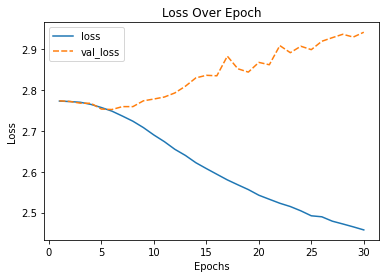

In [114]:
#cnn_history.summary()
df_cnn_history = pd.DataFrame(cnn_history.history.history)
df_cnn_history.index = np.arange(1, len(df_cnn_history)+1)

plt.title('Loss Over Epoch')
sns.lineplot(data=df_cnn_history[['loss', 'val_loss']])
plt.xlabel('Epochs')
plt.ylabel('Loss');

# Model and Error Analysis

In [115]:
def mbti_accuracy(y_true, y_pred):
    # Measures accuracy for mbti classification across 5 accuracy metrics:
    # one match, two matches, three matches, perfect match, average match
    
    # Average match is number of letters match / 4
    
    # Comparing 'ENFJ' as the true class and 'ENFP' as the predicted class,
    # this function returns...
    # [1, 1, 1, 0, 0.75]
     
    # Get index from one hot encoding of y_true
    # Get index of highest softmax/probability output in y_pred
    y_true_index = np.argmax(y_true, axis=1)
    y_pred_index = np.argmax(y_pred, axis=1)
    
    # Use the index to identify the corresponding mbti class
    mbti_num_encoding_list = list(mbti_num_encoding)
    y_true_mbti = [mbti_num_encoding_list[idx] for idx in y_true_index]
    y_pred_mbti = [mbti_num_encoding_list[idx] for idx in y_pred_index]
    
    one_match = []
    two_matches = []
    three_matches = []
    perfect_match = []
    
    # Perform mbti accuracy measurements
    sum_num_matches = 0
    for i in np.arange(len(y_true_mbti)):
        num_letter_matches = len(set(y_true_mbti[i]) & set(y_pred_mbti[i]))
        
        # At least 1 letter match
        if num_letter_matches == 1:
            one_match += [True]
            two_matches += [False]
            three_matches += [False]
            perfect_match += [False]
            
        # At least 2 letter matches
        elif num_letter_matches == 2:
            one_match += [True]
            two_matches += [True]
            three_matches += [False]
            perfect_match += [False]
            
        # At least 3 letter matches
        elif num_letter_matches == 3:
            one_match += [True]
            two_matches += [True]
            three_matches += [True]
            perfect_match += [False]
           
        # Perfect match
        else:
            one_match += [True]
            two_matches += [True]
            three_matches += [True]
            perfect_match += [True]
        
    # Average/partial matches
        sum_num_matches += num_letter_matches
    avg_num_matches = sum_num_matches/(len(y_true_mbti)*4)*100
    
    return np.round([np.mean(one_match)*100, 
                     np.mean(two_matches)*100, 
                     np.mean(three_matches)*100, 
                     np.mean(perfect_match)*100, 
                     avg_num_matches], 
                    2)


In [116]:
training_acc_metrics = np.append(np.array(['Train', language, 'CNN', X_train.shape[0]]), 
                                 mbti_accuracy(y_train, cnn_history.predict(X_train)))
testing_acc_metrics = np.append(np.array(['Test', language, 'CNN', X_test.shape[0]]),
                                mbti_accuracy(y_test, cnn_history.predict(X_test)))

acc_metrics = np.vstack((training_acc_metrics, testing_acc_metrics))

acc_metrics_summary = pd.DataFrame(acc_metrics, columns=['Data',
                                                         'Language',
                                                         'Model',
                                                         'Number of Samples',
                                                         'At Least 1 Match', 
                                                         'At Least 2 Matches', 
                                                         'At Least 3 Matches', 
                                                         'Perfect Match', 
                                                         'Average Match'])
acc_metrics_summary

,Data,Language,Model,Number of Samples,At Least 1 Match,At Least 2 Matches,At Least 3 Matches,Perfect Match,Average Match
0,Train,Spanish,CNN,20000,100.0,77.44,43.06,19.58,55.05
1,Test,Spanish,CNN,5000,100.0,72.68,34.74,12.36,48.48


In [117]:
filepath = '../NLP_MBTI_Classification/results_summary/'

In [118]:
csv_filepath = filepath+'cnn_'+language.lower()+'_summary.csv'
acc_metrics_summary.to_csv(csv_filepath)

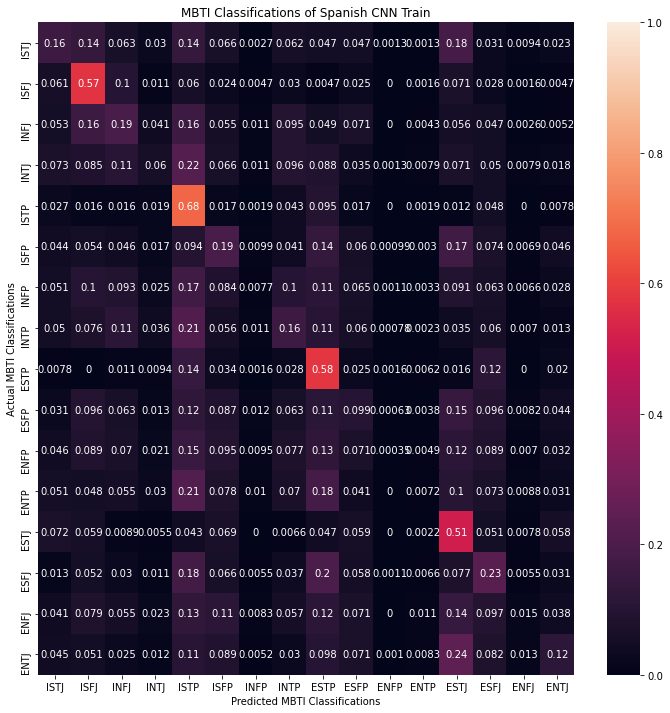

In [119]:
cf_matrix = confusion_matrix(np.argmax(y_train, axis=1), 
                             np.argmax(cnn_history.predict(X_train), axis=1),
                             normalize='true')


plt.figure(figsize=(12, 12))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels=list(mbti_num_encoding),
            yticklabels=list(mbti_num_encoding),
            vmin=0, vmax=1)
plt.title("MBTI Classifications of "+language+" CNN Train")
plt.ylabel("Actual MBTI Classifications")
plt.xlabel("Predicted MBTI Classifications")

matrix_train_filepath = filepath+'cnn_'+language.lower()+'_train'+'_confusion_matrix.png'
plt.savefig(matrix_train_filepath, transparent=True);

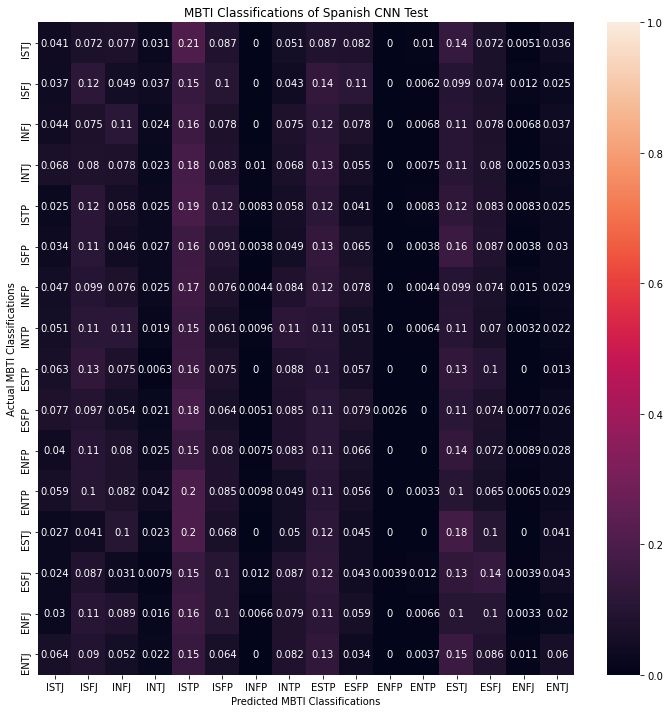

In [120]:
cf_matrix = confusion_matrix(np.argmax(y_test, axis=1), 
                             np.argmax(cnn_history.predict(X_test), axis=1),
                             normalize='true')


plt.figure(figsize=(12, 12))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels=list(mbti_num_encoding),
            yticklabels=list(mbti_num_encoding),
            vmin=0, vmax=1)
plt.title("MBTI Classifications of "+language+" CNN Test")
plt.ylabel("Actual MBTI Classifications")
plt.xlabel("Predicted MBTI Classifications")

matrix_test_filepath = filepath+'cnn_'+language.lower()+'_test'+'_confusion_matrix.png'
plt.savefig(matrix_test_filepath, transparent=True);